In [1]:
# Version check. Written for Python 3.5.4
import sys
print(sys.version)
#3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 18:10:19) 
#[GCC 7.2.0]

import matplotlib
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.axes as axes
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sympy import *
from sympy.utilities.autowrap import autowrap
import re

%matplotlib inline

3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]


In [2]:
# Define the path to the input folder containing the output parameters
inputFolder = "/Users/muriel/Documents/LACDR/Projects/E2S/Modeling/Output/E2Model/version2/MN03/E2/20221222_124352/"#M010/E2/20220613_171703/" # Write down the path to the folder that
# contains the parameter estimates of all the finished runs

# Define the path to the parameter estimates
filename = "20221222_124352_MH_MN03Model_parameterEstimates_parmset1_cost_263.79.csv"

# Read in the file with the parameter estimates
file = inputFolder+filename

In [3]:
# Define the parameters
parameterEst = pd.read_csv(file)

pAllNew = parameterEst["est_value"].values

# Make the parameters global variables
for i in parameterEst.iterrows():
    sText = str(parameterEst.iloc[i[0], 0]) + " = " + str(parameterEst.iloc[i[0], 2])
    print(sText)
    exec(sText)

CONC2_init = 0.009051742611076895
CONC3_init = 0.03230828351972203
CONC4_init = 0.04625640325445463
CONC5_init = 0.06998756344233316
CONC6_init = 0.11290013597772128
ER_init = 0.02581993692281796
GREB1_init = 0.8344153195718149
PR_init = 0.7813967724970137
TFF1_init = 0.9592714759583952
d_er = 0.027928548129323653
d_pr = 0.021659168723035457
d_greb1 = 0.15495983137993044
d_tff1 = 0.6517098044073002
b_e2er = 7.487415058979122
d_e2er = 0.35903400546855924
b_e2ergreb1 = 0.03690059183270825
d_e2ergreb1 = 9.621863834603661e-14
stim_pr = 63.5022447577693
stim_greb1 = 673.3138826360424
stim_tff1 = 952.1967002772383
s_er = 0.0007211133510450223
s_pr = 0.016924404535148173
s_greb1 = 0.12930085722167922
s_tff1 = 0.625166625970348


In [4]:
CONC1_init = 0.001
Ce2er_init = 0
Ce2ergreb1_init = 0


In [5]:
# PART 1: constant oscillations
def E2signaling(z,t):    
    
    # State vars
    E2, ER, Ce2er, GREB1, Ce2ergreb1, PR,  TFF1  = z
    
    # E2 signaling
    dE2 = - b_e2er * E2 * ER / (1 + E2 + ER)
    dER = s_er - b_e2er * E2 * ER / (1 + E2 + ER) - d_er * ER 
    dCe2er = b_e2er * E2 * ER / (1 + E2 + ER) - b_e2ergreb1 * Ce2er * GREB1 / (1 + Ce2er + GREB1) - d_e2er * Ce2er

    # Formation of second complex E2/ER/GREB1 (C2)
    dGREB1 = s_greb1 + stim_greb1 * Ce2ergreb1 / (1 + Ce2ergreb1) - b_e2ergreb1 * Ce2er * GREB1 / (1 + Ce2er + GREB1) - d_greb1 * GREB1
    dCe2ergreb1 = b_e2ergreb1 * Ce2er * GREB1 / (1 + Ce2er + GREB1) - d_e2ergreb1 * Ce2ergreb1

    # Activation of downstream targets
    dPR = s_pr + stim_pr * Ce2ergreb1 / (1 + Ce2ergreb1) - d_pr * PR 
    dTFF1 = s_tff1 + stim_tff1 * Ce2ergreb1  / (1 + Ce2ergreb1) - d_tff1 * TFF1

    return [dE2, dER, dCe2er, dGREB1, dCe2ergreb1, dPR, dTFF1]


In [6]:
# Recalculate steady state constraints
s_er = d_er * ER_init
s_pr = d_pr * PR_init 
s_greb1 = d_greb1 * GREB1_init
s_tff1 = d_tff1 * TFF1_init

s_er, s_pr, s_greb1, s_tff1

(0.0007211133510450223,
 0.016924404535148173,
 0.12930085722167922,
 0.6251666259703479)

In [7]:
# Check steady states

# E2 signaling
dE2 = - b_e2er * 0 * ER_init / (1 + 0 + ER_init)
dER = s_er - b_e2er * 0 * ER_init / (1 + 0 + ER_init) - d_er * ER_init 
dCe2er = b_e2er * 0 * ER_init / (1 + 0 + ER_init) - b_e2ergreb1 * Ce2er_init * GREB1_init / (1 + Ce2er_init + GREB1_init) - d_e2er * Ce2er_init

# Formation of second complex E2/ER/GREB1 (C2)
dGREB1 = s_greb1 + stim_greb1 * Ce2ergreb1_init / (1 + Ce2ergreb1_init) - b_e2ergreb1 * Ce2er_init * GREB1_init / (1 + Ce2er_init + GREB1_init) - d_greb1 * GREB1_init
dCe2ergreb1 = b_e2ergreb1 * Ce2er_init * GREB1_init / (1 + Ce2er_init + GREB1_init) - d_e2ergreb1 * Ce2ergreb1_init

# Activation of downstream targets
dPR = s_pr + stim_pr * Ce2ergreb1_init / (1 + Ce2ergreb1_init) - d_pr * PR_init
dTFF1 = s_tff1 + stim_tff1 * Ce2ergreb1_init  / (1 + Ce2ergreb1_init) - d_tff1 * TFF1_init


# print outcome
dE2, dER, dCe2er, dGREB1, dCe2ergreb1, dGREB1, dPR, dTFF1

(-0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)

In [38]:
# PART 0: Run simulation and save output for plotting in R. 

# Initial conditions
z_part0 = [CONC1_init, ER_init, Ce2er_init, GREB1_init, Ce2ergreb1_init, PR_init, TFF1_init]

# PART 1 time span 
t_part0 = np.linspace(1, 55, 55)

# Run simulation
out_part0 = odeint(E2signaling, z_part0, t_part0)

d = {'dose_nM': np.repeat(0.001,55*3), 
     'timeID': np.hstack(np.repeat([np.arange(1,56,1)],3, axis = 0)), 
     "StateVar": ["GREB1"]*55 + ["PR"]*55 + ["TFF1"]*55,
    "GFP": np.hstack((out_part0[:,3]+out_part0[:,4],out_part0[:,5],out_part0[:,6]))}

simu_data = pd.DataFrame(data = d)
simulations = [out_part0]

for dose,conc in enumerate([CONC2_init, CONC3_init, CONC4_init, CONC5_init, CONC6_init]):

    # Initial conditions
    z_part0 = [conc, ER_init, Ce2er_init, GREB1_init, Ce2ergreb1_init, PR_init, TFF1_init]

    # PART 1 time span 
    t_part0 = np.linspace(1, 55, 55)

    # Run simulation
    out_part0 = odeint(E2signaling, z_part0, t_part0)
    
    nominal_conc = [0.01,0.1,1,10,100][dose]

    d = {'dose_nM': np.repeat(nominal_conc,55*3), 'timeID': np.hstack(np.repeat([np.arange(1,56,1)],3, axis = 0)), "StateVar": ["GREB1"]*55 + ["PR"]*55 + ["TFF1"]*55,
        "GFP": np.hstack((out_part0[:,3]+out_part0[:,4],out_part0[:,5],out_part0[:,6]))}
    
    data = pd.DataFrame(data = d)
    
    simu_data = pd.concat([simu_data, data])
    
    simulations.append(out_part0)

simu_data

simu_data.to_csv("MN03_simu_data.csv")




,dose_nM,timeID,StateVar,GFP
0,0.001,1,GREB1,0.834415
1,0.001,2,GREB1,0.834712
2,0.001,3,GREB1,0.836405
3,0.001,4,GREB1,0.840071
4,0.001,5,GREB1,0.845753
...,...,...,...,...
160,100.000,51,TFF1,6.651471
161,100.000,52,TFF1,6.735984
162,100.000,53,TFF1,6.820460
163,100.000,54,TFF1,6.904894


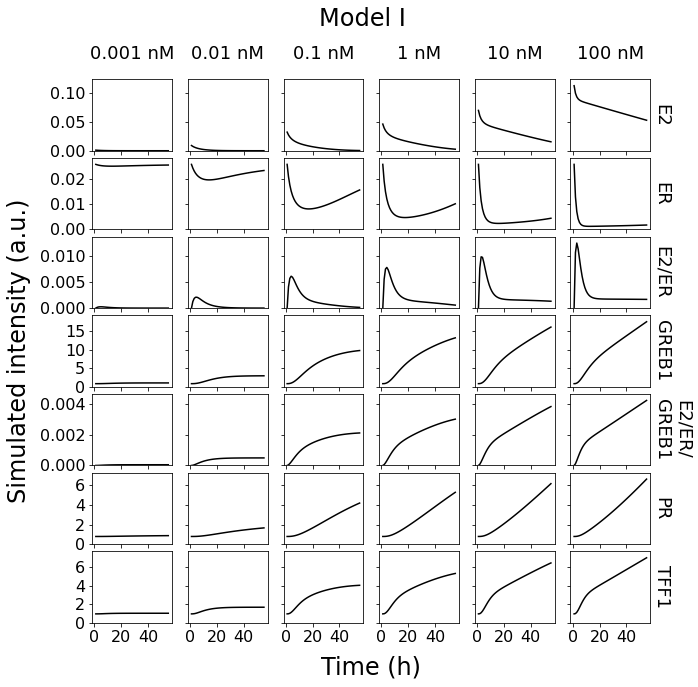

In [74]:
# PART 1.5: Make a figure for inner states of the model simulations
varnames = ["E2","ER","E2/ER","GREB1","E2/ER/GREB1","PR","TFF1"]
varnames_total = ["E2","ER","E2/ER","GREB1","E2/ER/\nGREB1","PR","TFF1"]
doses = ["0.001 nM", "0.01 nM", "0.1 nM", "1 nM", "10 nM", "100 nM"]

nrows = len(varnames_total)
fig, ax = plt.subplots(nrows,len(simulations),sharex=True, sharey='row')

for d, dose in enumerate(doses):
    # Set dose title
    ax[0,d].set_title(dose,fontdict={'fontsize': 18}, pad=20)

    for row in range(0,nrows):
        ax[row, d].set_ylim(ymin = 0, ymax = max(simulations[d][:,row])+0.1*max(simulations[d][:,row]))
        ax[row,d].plot(t_part0,simulations[d][:,row], color = "#000000")
        ax[row, d].tick_params(axis = 'both', labelsize=16)

        ax[row, len(simulations)-1].set_ylabel(varnames_total[row], rotation = -90, fontsize = 18)
        ax[row, len(simulations)-1].yaxis.set_label_coords(1.03,0.5)
        ax[row, len(simulations)-1].locator_params(axis='both', nbins=4)

# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
fig.subplots_adjust(hspace=0.1)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.suptitle("Model I", fontsize = 24)

# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Time (h)", fontsize=24, labelpad=16)
plt.ylabel("Simulated intensity (a.u.)", fontsize=24, labelpad=38)

plt.savefig('Figures/FigS1A_MN03_innerstates.pdf', bbox_inches='tight')


Text(0, 0.5, 'Proteins')

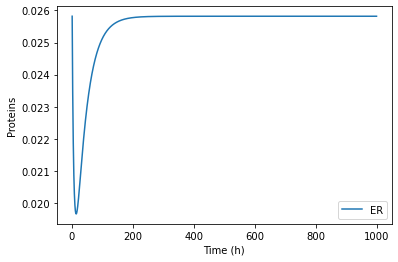

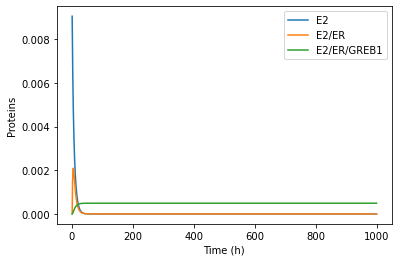

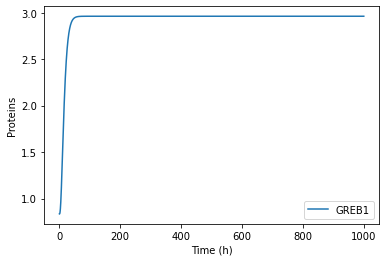

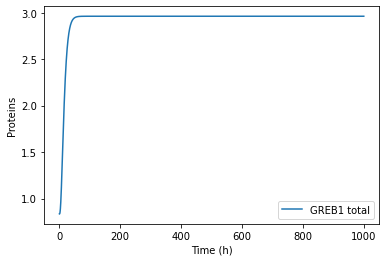

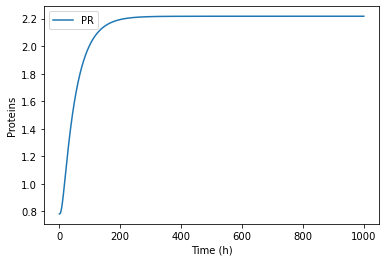

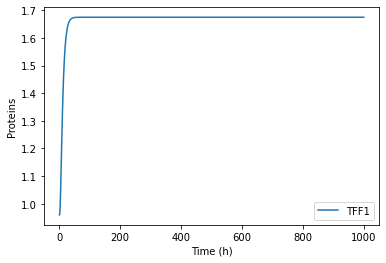

In [9]:
# PART 1: simulations for long period, to see if protein levels return to initial state
# Initial conditions
z_part1 = [CONC2_init, ER_init, Ce2er_init, GREB1_init, Ce2ergreb1_init, PR_init, TFF1_init]

# PART 1 time span 
t_part1 = np.linspace(1, 1000, 8000)

# Run simulation
out_part1 = odeint(E2signaling, z_part1, t_part1)

# PART 1 plotting
# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part1,out_part1[:,1],label='ER', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')


# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part1,out_part1[:,0],label='E2', linestyle = 'solid')
ax.plot(t_part1,out_part1[:,2],label='E2/ER', linestyle = 'solid')
ax.plot(t_part1,out_part1[:,4],label='E2/ER/GREB1', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part1, out_part1[:,3], label='GREB1', linestyle = 'solid') 
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')



# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part1,out_part1[:,3] + out_part1[:,4], label='GREB1 total', linestyle = 'solid') 
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part1,out_part1[:,5], label='PR', linestyle = 'solid') 
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')


# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part1,out_part1[:,6],label='TFF1', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')



Text(0, 0.5, 'Proteins')

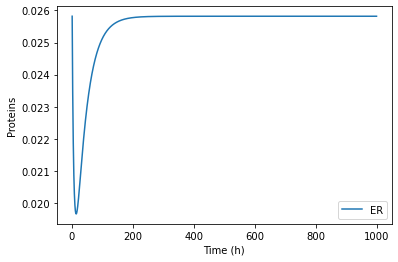

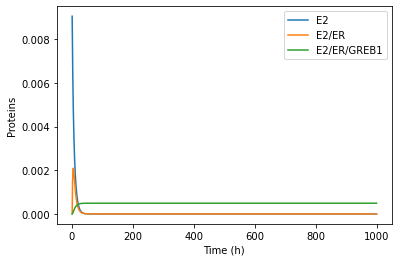

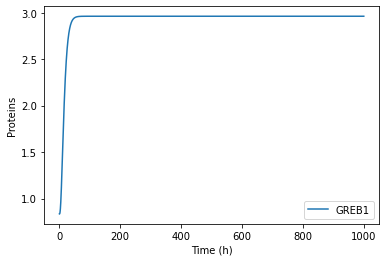

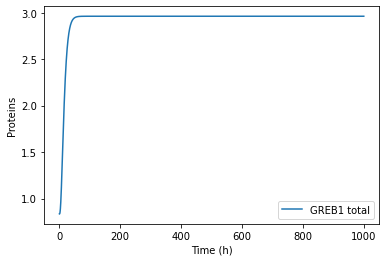

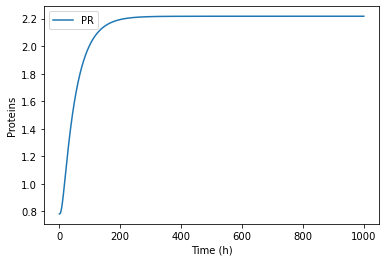

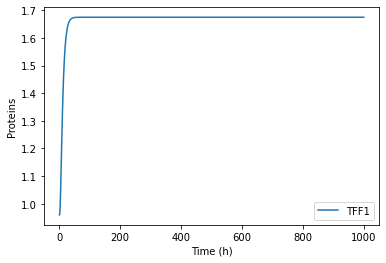

In [10]:
# PART 2: simulations to see whether at constant E2, proteins go to a new equilibrium.

# Model
def E2signaling_constant(z,t):    
    
    # State vars
    E2, ER, Ce2er, GREB1, Ce2ergreb1, PR, TFF1  = z
    
    dE2 = 0
    dER = s_er - b_e2er * E2 * ER / (1 + E2 + ER) - d_er * ER 
    dCe2er = b_e2er * E2 * ER / (1 + E2 + ER) - b_e2ergreb1 * Ce2er * GREB1 / (1 + Ce2er + GREB1) - d_e2er * Ce2er

    # Formation of second complex E2/ER/GREB1 (C2)
    dGREB1 = s_greb1 + stim_greb1 * Ce2ergreb1 / (1 + Ce2ergreb1) - b_e2ergreb1 * Ce2er * GREB1 / (1 + Ce2er + GREB1) - d_greb1 * GREB1
    dCe2ergreb1 = b_e2ergreb1 * Ce2er * GREB1 / (1 + Ce2er + GREB1) - d_e2ergreb1 * Ce2ergreb1

    # Activation of downstream targets
    dPR = s_pr + stim_pr * Ce2ergreb1 / (1 + Ce2ergreb1) - d_pr * PR 
    dTFF1 = s_tff1 + stim_tff1 * Ce2ergreb1  / (1 + Ce2ergreb1) - d_tff1 * TFF1

    return [dE2, dER, dCe2er, dGREB1, dCe2ergreb1, dPR, dTFF1]


# Initial conditions
z_part2 = [CONC2_init, ER_init, Ce2er_init, GREB1_init, Ce2ergreb1_init, PR_init, TFF1_init]

# PART 2 time span 
t_part2 = np.linspace(1, 2000, 10000)

# Run simulation
out_part2 = odeint(E2signaling_constant, z_part2, t_part2)

# PART 1 plotting
# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part1,out_part1[:,1],label='ER', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')


# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part1,out_part1[:,0],label='E2', linestyle = 'solid')
ax.plot(t_part1,out_part1[:,2],label='E2/ER', linestyle = 'solid')
ax.plot(t_part1,out_part1[:,4],label='E2/ER/GREB1', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part1, out_part1[:,3], label='GREB1', linestyle = 'solid') 
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')



# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part1,out_part1[:,3] + out_part1[:,4], label='GREB1 total', linestyle = 'solid') 
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part1,out_part1[:,5], label='PR', linestyle = 'solid') 
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')


# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part1,out_part1[:,6],label='TFF1', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')




Do knock down 'experiments'

In [11]:
# PART 3: simulations to see whether the KD experiments are correctly reproduced

# Models
def KD_GREB1(z,t):    
    
    # State vars
    E2, ER, Ce2er, GREB1, Ce2ergreb1, PR, TFF1  = z
    
    dE2 = - b_e2er * E2 * ER / (1 + E2 + ER)
    dER = s_er - b_e2er * E2 * ER / (1 + E2 + ER) - d_er * ER 
    dCe2er = b_e2er * E2 * ER / (1 + E2 + ER) - b_e2ergreb1 * Ce2er * GREB1 / (1 + Ce2er + GREB1) - d_e2er * Ce2er

    # Formation of second complex E2/ER/GREB1 (C2)
    dGREB1 = 0#s_greb1 + stim_greb1 * Ce2ergreb1 / (1 + Ce2ergreb1) - b_e2ergreb1 * Ce2er * GREB1 / (1 + Ce2er + GREB1) - d_greb1 * GREB1
    dCe2ergreb1 = b_e2ergreb1 * Ce2er * GREB1 / (1 + Ce2er + GREB1) - d_e2ergreb1 * Ce2ergreb1

    # Activation of downstream targets
    dPR = s_pr + stim_pr * Ce2ergreb1 / (1 + Ce2ergreb1) - d_pr * PR 
    dTFF1 = s_tff1 + stim_tff1 * Ce2ergreb1  / (1 + Ce2ergreb1) - d_tff1 * TFF1

    return [dE2, dER, dCe2er, dGREB1, dCe2ergreb1, dPR, dTFF1]


def KD_PGR(z,t):    
    
    # State vars
    E2, ER, Ce2er, GREB1, Ce2ergreb1, PR, TFF1  = z
    
    dE2 = - b_e2er * E2 * ER / (1 + E2 + ER)
    dER = s_er - b_e2er * E2 * ER / (1 + E2 + ER) - d_er * ER 
    dCe2er = b_e2er * E2 * ER / (1 + E2 + ER) - b_e2ergreb1 * Ce2er * GREB1 / (1 + Ce2er + GREB1) - d_e2er * Ce2er

    # Formation of second complex E2/ER/GREB1 (C2)
    dGREB1 = s_greb1 + stim_greb1 * Ce2ergreb1 / (1 + Ce2ergreb1) - b_e2ergreb1 * Ce2er * GREB1 / (1 + Ce2er + GREB1) - d_greb1 * GREB1
    dCe2ergreb1 = b_e2ergreb1 * Ce2er * GREB1 / (1 + Ce2er + GREB1) - d_e2ergreb1 * Ce2ergreb1

    # Activation of downstream targets
    dPR = 0#s_pr + stim_pr * Ce2ergreb1 / (1 + Ce2ergreb1) - d_pr * PR 
    dTFF1 = s_tff1 + stim_tff1 * Ce2ergreb1  / (1 + Ce2ergreb1) - d_tff1 * TFF1

    return [dE2, dER, dCe2er, dGREB1, dCe2ergreb1, dPR, dTFF1]


def KD_TFF1(z,t):    
    
    # State vars
    E2, ER, Ce2er, GREB1, Ce2ergreb1, PR, TFF1  = z
    
    dE2 = - b_e2er * E2 * ER / (1 + E2 + ER)
    dER = s_er - b_e2er * E2 * ER / (1 + E2 + ER) - d_er * ER 
    dCe2er = b_e2er * E2 * ER / (1 + E2 + ER) - b_e2ergreb1 * Ce2er * GREB1 / (1 + Ce2er + GREB1) - d_e2er * Ce2er

    # Formation of second complex E2/ER/GREB1 (C2)
    dGREB1 = s_greb1 + stim_greb1 * Ce2ergreb1 / (1 + Ce2ergreb1) - b_e2ergreb1 * Ce2er * GREB1 / (1 + Ce2er + GREB1) - d_greb1 * GREB1
    dCe2ergreb1 = b_e2ergreb1 * Ce2er * GREB1 / (1 + Ce2er + GREB1) - d_e2ergreb1 * Ce2ergreb1

    # Activation of downstream targets
    dPR = s_pr + stim_pr * Ce2ergreb1 / (1 + Ce2ergreb1) - d_pr * PR 
    dTFF1 = 0#s_tff1 + stim_tff1 * Ce2ergreb1  / (1 + Ce2ergreb1) - d_tff1 * TFF1

    return [dE2, dER, dCe2er, dGREB1, dCe2ergreb1, dPR, dTFF1]



In [32]:
# Initial conditions
z_mock = [CONC6_init, ER_init, Ce2er_init, GREB1_init, Ce2ergreb1_init, PR_init, TFF1_init]
z_greb1 = [CONC6_init, ER_init, Ce2er_init, 0, Ce2ergreb1_init, PR_init, TFF1_init]
z_pr = [CONC6_init, ER_init, Ce2er_init, GREB1_init, Ce2ergreb1_init, 0, TFF1_init]
z_tff1 = [CONC6_init, ER_init, Ce2er_init, GREB1_init, Ce2ergreb1_init, PR_init, 0]

t_kd = np.linspace(1, 24, 24)

mock = odeint(E2signaling,z_mock,t_kd)
kd_greb1 = odeint(KD_GREB1,z_greb1,t_kd)
kd_pr = odeint(KD_PGR,z_pr,t_kd)
kd_tff1 = odeint(KD_TFF1,z_tff1,t_kd)



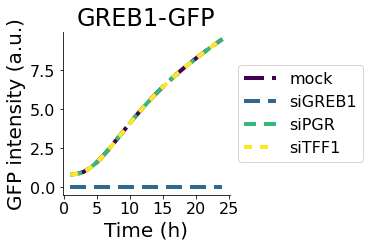

In [33]:
# Plot simulation results for GREB1 protein
fig,ax = plt.subplots(figsize=(3,3))
ax.plot(t_kd,mock[:,3]+mock[:,4],label='mock', dashes = [5, 2], color = "#440154FF", linewidth = 4)
ax.plot(t_kd,kd_greb1[:,3]+kd_greb1[:,4],label='siGREB1', dashes = [4, 2], color = "#31688EFF", linewidth = 4)
ax.plot(t_kd,kd_pr[:,3]+kd_pr[:,4],label='siPGR', dashes = [3, 2], color = "#35B779FF", linewidth = 4)
ax.plot(t_kd,kd_tff1[:,3]+kd_tff1[:,4],label='siTFF1', dashes = [2, 2], color = "#FDE725FF", linewidth = 4)

ax.set_title('GREB1-GFP', fontsize=24)
ax.set_xlabel('Time (h)', fontsize=20)
ax.set_ylabel('GFP intensity (a.u.)', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 16})
ax.xaxis.set_ticks(np.arange(0, 26, 5))
plt.savefig('Figures/Fig2D_GREB1_KDsimu.pdf', bbox_inches='tight')

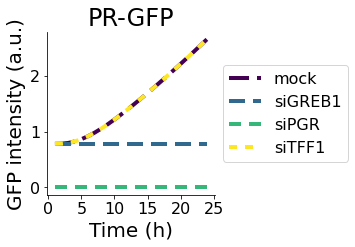

In [34]:
# Plot simulation results for PR protein
fig,ax = plt.subplots(figsize=(3,3))
ax.plot(t_kd,mock[:,5],label='mock', dashes = [5, 2], color = "#440154FF", linewidth = 4)
ax.plot(t_kd,kd_greb1[:,5],label='siGREB1', dashes = [4, 2], color = "#31688EFF", linewidth = 4)
ax.plot(t_kd,kd_pr[:,5],label='siPGR', dashes = [3, 2], color = "#35B779FF", linewidth = 4)
ax.plot(t_kd,kd_tff1[:,5],label='siTFF1', dashes = [2, 2], color = "#FDE725FF", linewidth = 4)

ax.set_title('PR-GFP', fontsize=24)
ax.set_xlabel('Time (h)', fontsize=20)
ax.set_ylabel('GFP intensity (a.u.)', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 16})
ax.xaxis.set_ticks(np.arange(0, 26, 5))
plt.savefig('Figures/Fig2D_PR_KDsimu.pdf', bbox_inches='tight')




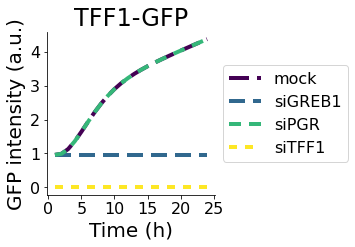

In [35]:
# Plot simulation results for TFF1 protein
fig,ax = plt.subplots(figsize=(3,3))
ax.plot(t_kd,mock[:,6],label='mock', dashes = [5, 2], color = "#440154FF", linewidth = 4)
ax.plot(t_kd,kd_greb1[:,6],label='siGREB1', dashes = [4, 2], color = "#31688EFF", linewidth = 4)
ax.plot(t_kd,kd_pr[:,6],label='siPGR', dashes = [3, 2], color = "#35B779FF", linewidth = 4)
ax.plot(t_kd,kd_tff1[:,6],label='siTFF1', dashes = [2, 2], color = "#FDE725FF", linewidth = 4)

ax.set_title('TFF1-GFP', fontsize=24)
ax.set_xlabel('Time (h)', fontsize=20)
ax.set_ylabel('GFP intensity (a.u.)', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 16})
ax.xaxis.set_ticks(np.arange(0, 26, 5))
plt.savefig('Figures/Fig2D_TFF1_KDsimu.pdf', bbox_inches='tight')



Text(0, 0.5, 'Proteins')

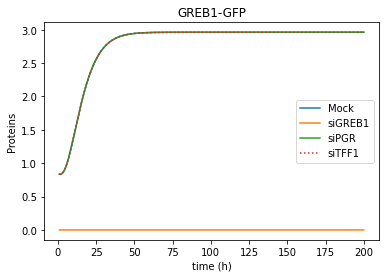

In [31]:
# Plot simulation results for GREB1 protein
fig,ax = plt.subplots()

ax.plot(t_kd,mock[:,3]+mock[:,4],label='Mock', linestyle = 'solid')
ax.plot(t_kd,kd_greb1[:,3]+kd_greb1[:,4],label='siGREB1', linestyle = 'solid')
ax.plot(t_kd,kd_pr[:,3]+kd_pr[:,4],label='siPGR', linestyle = 'solid')
ax.plot(t_kd,kd_tff1[:,3]+kd_tff1[:,4],label='siTFF1', linestyle = 'dotted')

ax.legend()
ax.set_title('GREB1-GFP')
ax.set_xlabel('time (h)')
ax.set_ylabel('Proteins')

Text(0, 0.5, 'Proteins')

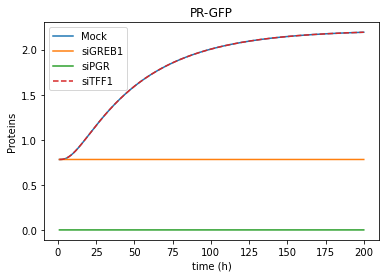

In [32]:
# Plot simulation results for PGR protein
fig,ax = plt.subplots()
ax.plot(t_kd,mock[:,5],label='Mock', linestyle = 'solid')
ax.plot(t_kd,kd_greb1[:,5],label='siGREB1', linestyle = 'solid')
ax.plot(t_kd,kd_pr[:,5],label='siPGR', linestyle = 'solid')
ax.plot(t_kd,kd_tff1[:,5],label='siTFF1', linestyle = 'dashed')

ax.legend()
ax.set_title('PR-GFP')
ax.set_xlabel('time (h)')
ax.set_ylabel('Proteins')

Text(0, 0.5, 'Proteins')

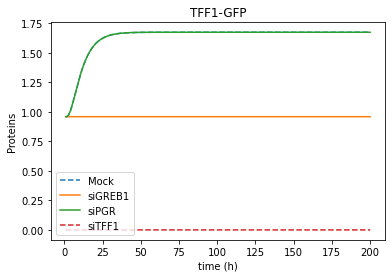

In [28]:
# Plot simulation results for PGR protein
fig,ax = plt.subplots()
ax.plot(t_kd,mock[:,6],label='Mock', linestyle = 'dashed')
ax.plot(t_kd,kd_greb1[:,6],label='siGREB1', linestyle = 'solid')
ax.plot(t_kd,kd_pr[:,6],label='siPGR', linestyle = 'solid')
ax.plot(t_kd,kd_tff1[:,6],label='siTFF1', linestyle = 'dashed')

ax.legend()
ax.set_title('TFF1-GFP')
ax.set_xlabel('time (h)')
ax.set_ylabel('Proteins')

Bifurcation analysis

In [ ]:
def model(z,t,p):    
    
    # State vars
    CDK1, APC, E2, ER, C1, PGR, C2, GREB1, CA, TFF1  = z
    
    a1 = p
    
    # Cell cycle
    dCDK1  = a1 - b1 * CDK1 * APC**n1 / (K1**n1 + APC**n1) + a3 * (1 - CDK1) * (CDK1**n3 / (K3**n3 + CDK1**n3))
    dAPC  =  a2 * (1 - APC) * CDK1**n2 / (K2**n2 + CDK1**n2) - b2 * APC

    # E2 signaling
    dE2 = - s_c1 * E2 * ER / (1 + E2 + ER)
    dER = - s_c1 * E2 * ER / (1 + E2 + ER) + s_er - d_er * ER 
    dC1 = s_c1 * E2 * ER / (1 + E2 + ER) + d_c2 * C2 - s_c2 * C1 * PGR - d_c1 * C1

    # Formation of second complex
    dPGR = s_pgr + d_c2 * C2 + i_pgr_ca * CA - s_c2 * C1 * PGR - d_pgr * PGR
    dC2 = d_ca * CA + s_c2 * C1 * PGR - d_c2 * C2 - s_ca * C2 * GREB1**4 / (K4**4 + GREB1**4)

    # Formation of third complex
    dGREB1 = stim_greb1_c2 * C2 + stim_greb1_ca * CA * (1 + k_greb1 * GREB1 / (1 + GREB1)) - d_greb1 * GREB1 
    dCA = s_ca * C2 * GREB1**4 / (K4**4 + GREB1**4) - d_ca * CA

    # Formation of downstream targets
    dTFF1 = i_tff1_c1 * C1 * PGR - d_tff1 * TFF1
   
    return [dCDK1, dAPC, dE2, dER, dC1, dPGR, dC2, dGREB1, dCA, dTFF1]


def bifurcate(seed:float, n_skip:int, n_iter:int, step:float=0.0001, p_min:float=0.0, p_max:float = 1, pos = 0, prot = ""):
    P = []
    V = []
    _range = np.linspace(p_min, p_max, int(1/step))
    for p in _range:
        v = seed
        t = np.linspace(1, n_skip+n_iter+1, (n_skip+n_iter+1))
        out = odeint(model,z,t,args = (p,))
        for i in range(n_skip+n_iter+1):
            if i >= n_skip:
                P.append(p)
                V.append(v)
            v = out[i,pos]
   
    plt.plot(P, V, ls='', marker=',', color='black')
    plt.ylim(0, 1)
    plt.xlim(p_min, p_max)
    plt.xlabel("a1")
    plt.ylabel(prot)
    plt.show()

In [ ]:
bifurcate(seed = 0.2, n_skip = 1000, n_iter = 20, step = 0.01, p_min=0, p_max = 0.2, pos = 0, prot = "CDK1")

In [ ]:
bifurcate(seed = 0.2, n_skip = 1000, n_iter = 20, step = 0.01, p_min=0, p_max = 0.2, pos = 1, prot = "APC")